In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

DIR = "C:/Users/Yipeng/Contest/BDCI2023/code/"
DIR_DATA_RAW = DIR + "data/"
DIR_DATA_PRE = DIR + "data/preprocessed/"
DIR_MODEL = DIR + "model/"
DIR_MODEL_LGB = DIR_MODEL + "lgb/"

In [2]:
import lightgbm as lgb

data_merged = pd.read_pickle(DIR_DATA_PRE + "data_merged.pkl")

In [3]:
lst = []
for day in [1,3,5,7,14,21,30,60,90]:
    lst.append(f"sales_{day}_mean")
    lst.append(f"sales_{day}_std")
    lst.append(f"sales_{day}_mean_change")
data_merged.drop(lst, axis=1, inplace=True)

In [4]:
# 加载模型
model = lgb.Booster(model_file=DIR_MODEL_LGB + 'all.txt')

In [22]:
ans_list = []

for date in pd.date_range('2023-08-31', '2023-09-14'):
    print(f"predict {date}")

    # 仅选择需要的行进行预测
    X_ans_single = data_merged[data_merged['date'] == date].drop(["quantity", "date"], axis=1)
    y_ans_single = model.predict(X_ans_single)
    
    # 准备用于更新的数据
    update_df = X_ans_single.copy()
    update_df['quantity'] = y_ans_single
    update_df['date'] = date
    ans_list.append(update_df[['date', 'store_id', 'sku_id', 'channel', 'quantity']])

    # print("updating ...")
    # # 更新 data_merged 中对应 date 的 quantity
    # data_merged.loc[data_merged['date'] == date, 'quantity'] = y_ans_single

    # next_date = date + pd.Timedelta(days=1)
    
    # # 更新统计数据
    # for day in [1,3,5,7,14,21,30,60,90]:
    #     print("day:", day)
    #     windowed = data_merged[data_merged['date'] < next_date].groupby(['store_id', 'sku_id', 'channel'])['quantity']
    #     data_merged.loc[data_merged['date'] == next_date, f'sales_{day}_mean'] = windowed.transform(lambda x: x.tail(day).mean())
    #     data_merged.loc[data_merged['date'] == next_date, f'sales_{day}_std'] = windowed.transform(lambda x: x.tail(day).std())
    #     data_merged.loc[data_merged['date'] == next_date, f'sales_{day}_mean_change'] = windowed.transform(lambda x: x.pct_change().tail(1))

# 合并结果
ans = pd.concat(ans_list)


predict 2023-08-31 00:00:00
predict 2023-09-01 00:00:00
predict 2023-09-02 00:00:00
predict 2023-09-03 00:00:00
predict 2023-09-04 00:00:00
predict 2023-09-05 00:00:00
predict 2023-09-06 00:00:00
predict 2023-09-07 00:00:00
predict 2023-09-08 00:00:00
predict 2023-09-09 00:00:00
predict 2023-09-10 00:00:00
predict 2023-09-11 00:00:00
predict 2023-09-12 00:00:00
predict 2023-09-13 00:00:00
predict 2023-09-14 00:00:00


In [23]:
ans = pd.concat(ans_list)

In [24]:
ans['quantity'] = ans['quantity'].apply(lambda x: 0 if x < 0.5 else ceil(x))

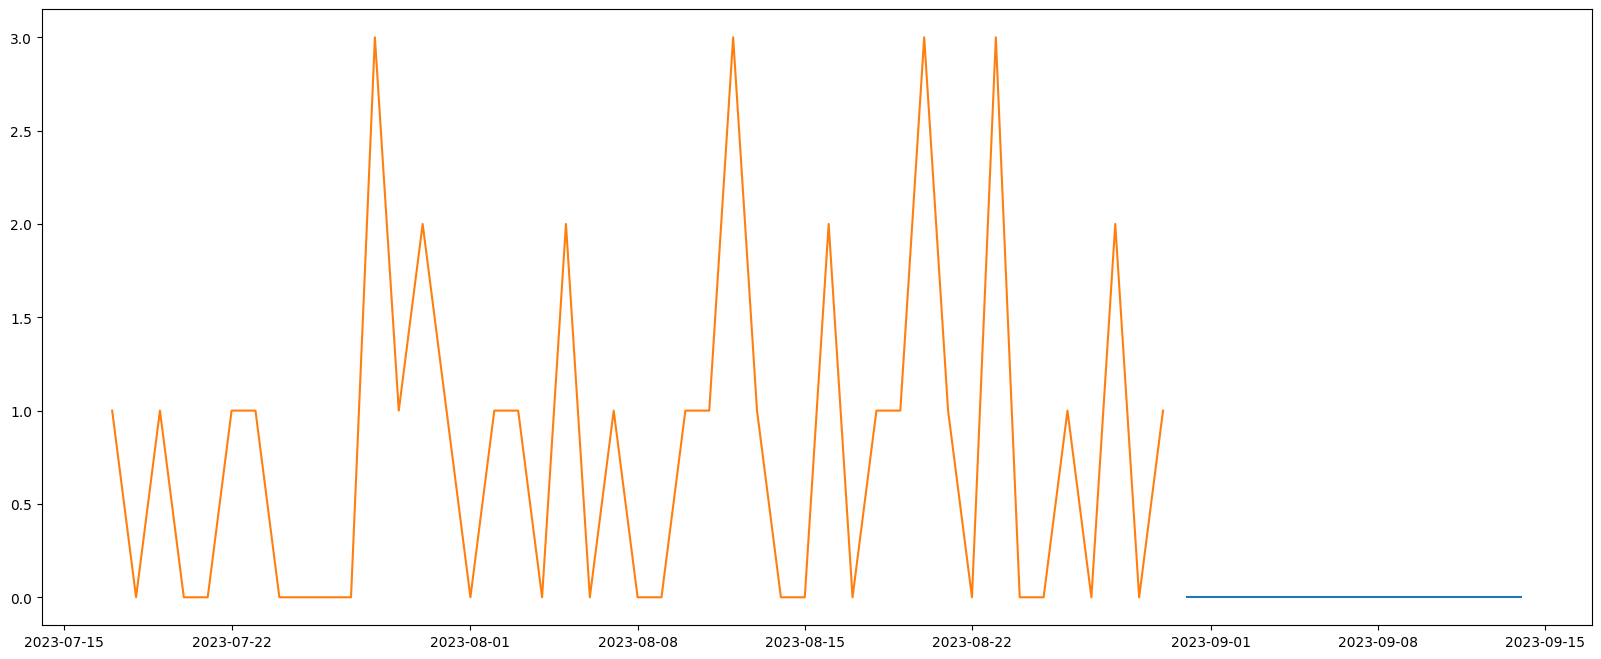

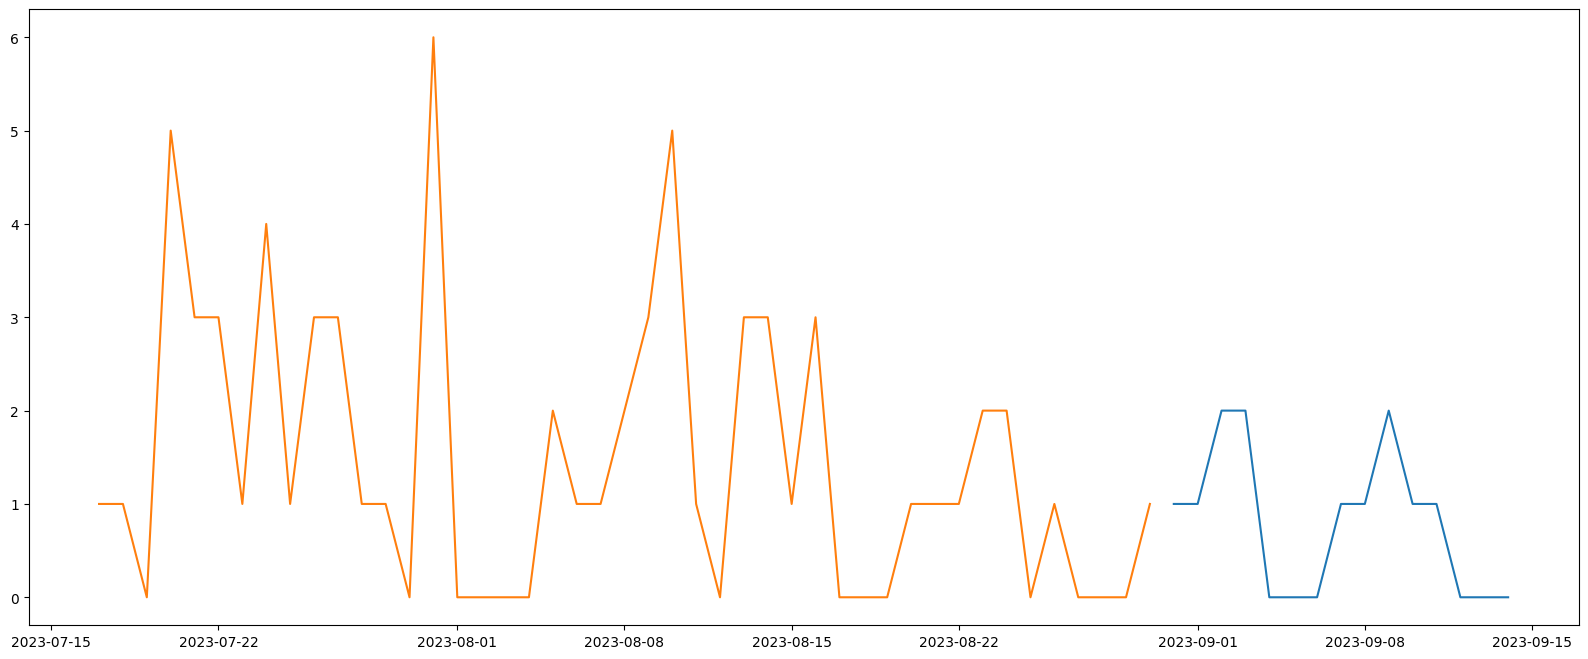

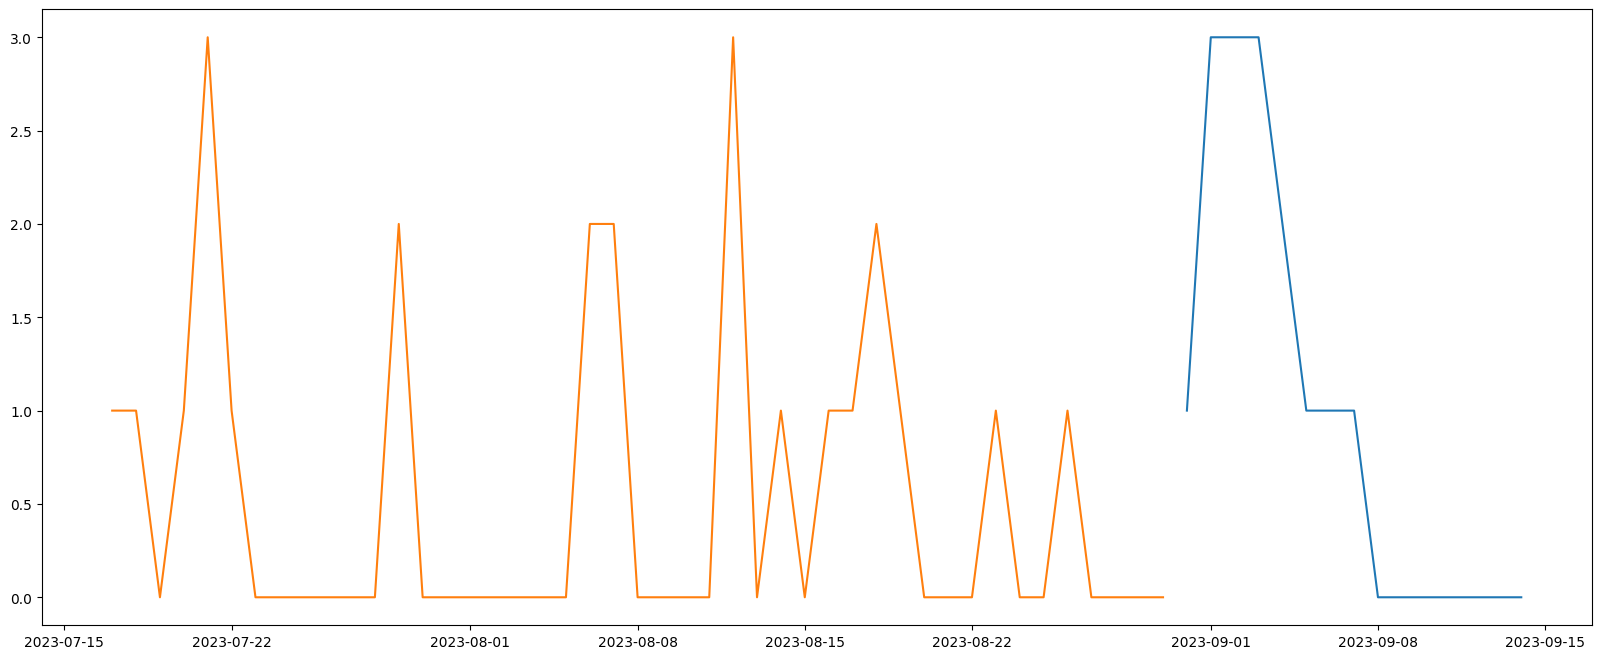

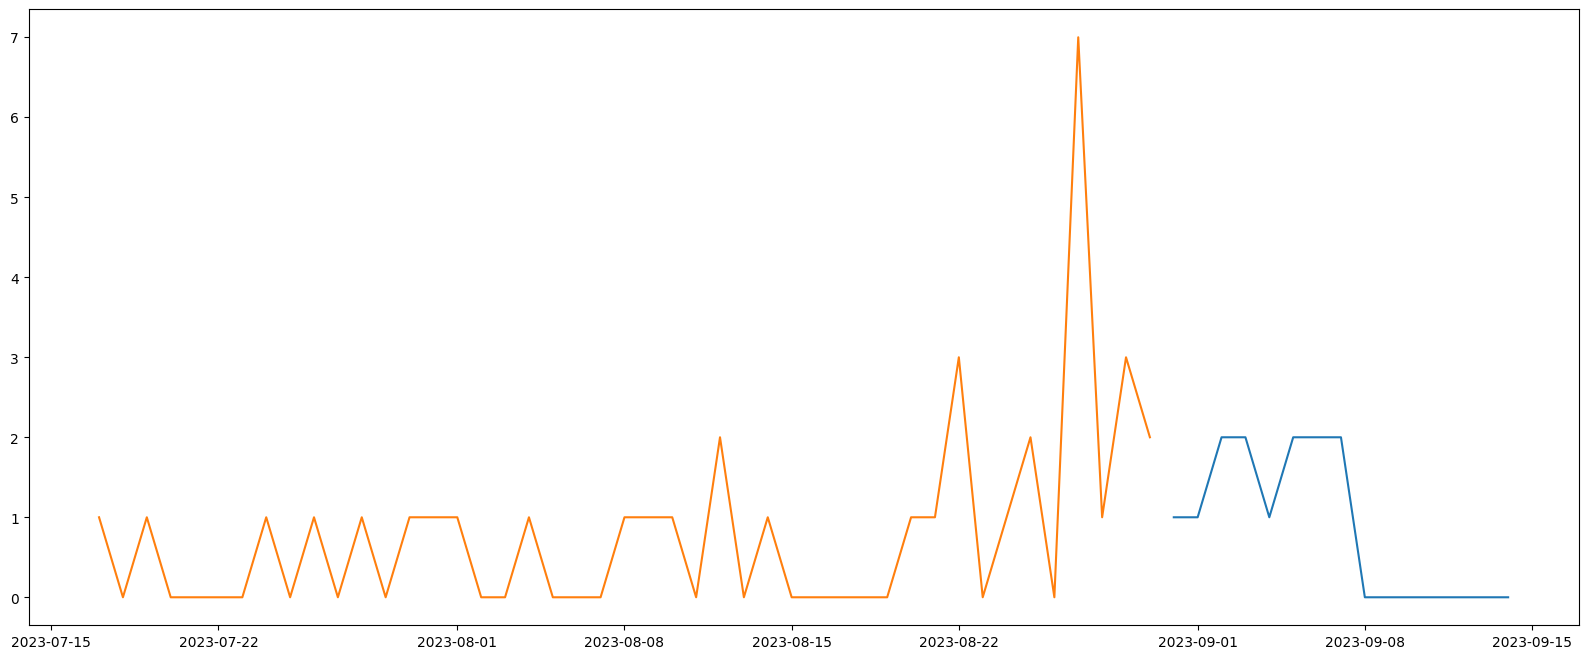

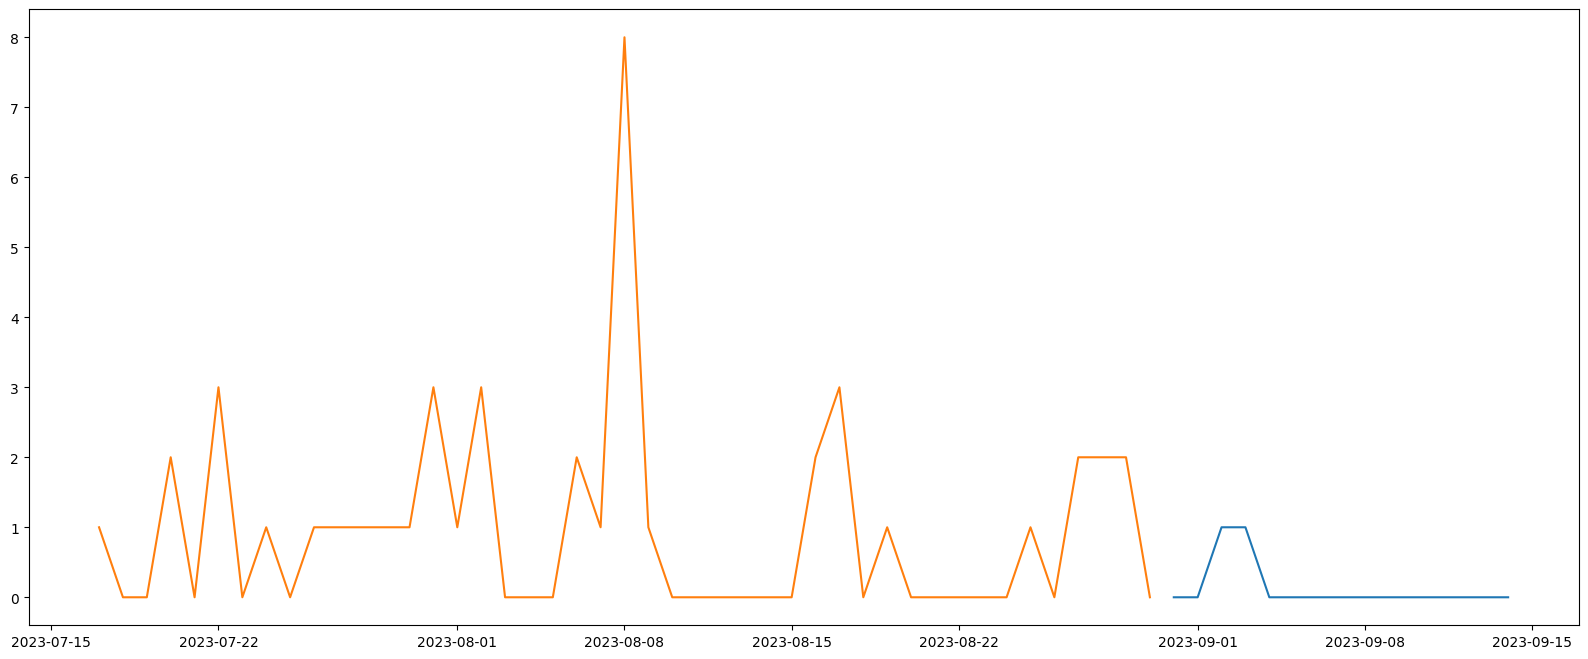

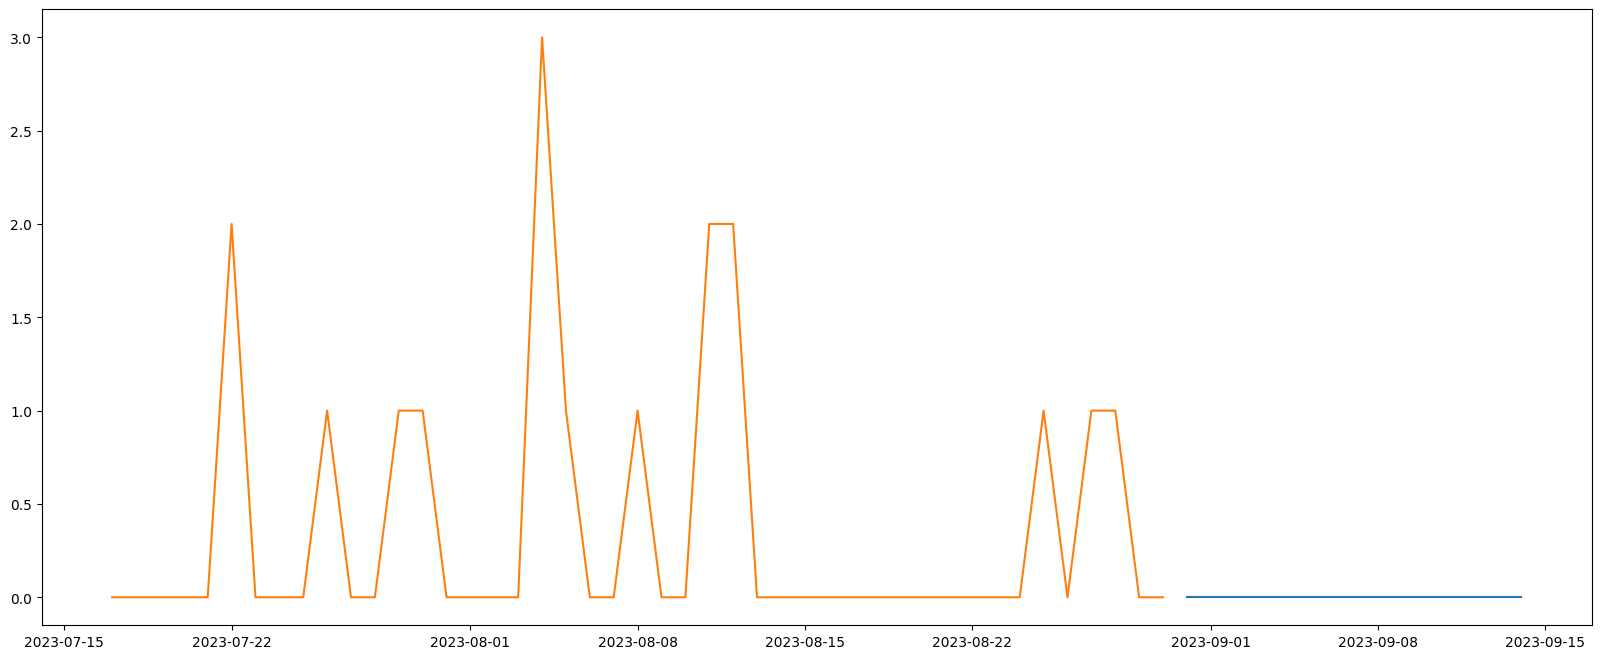

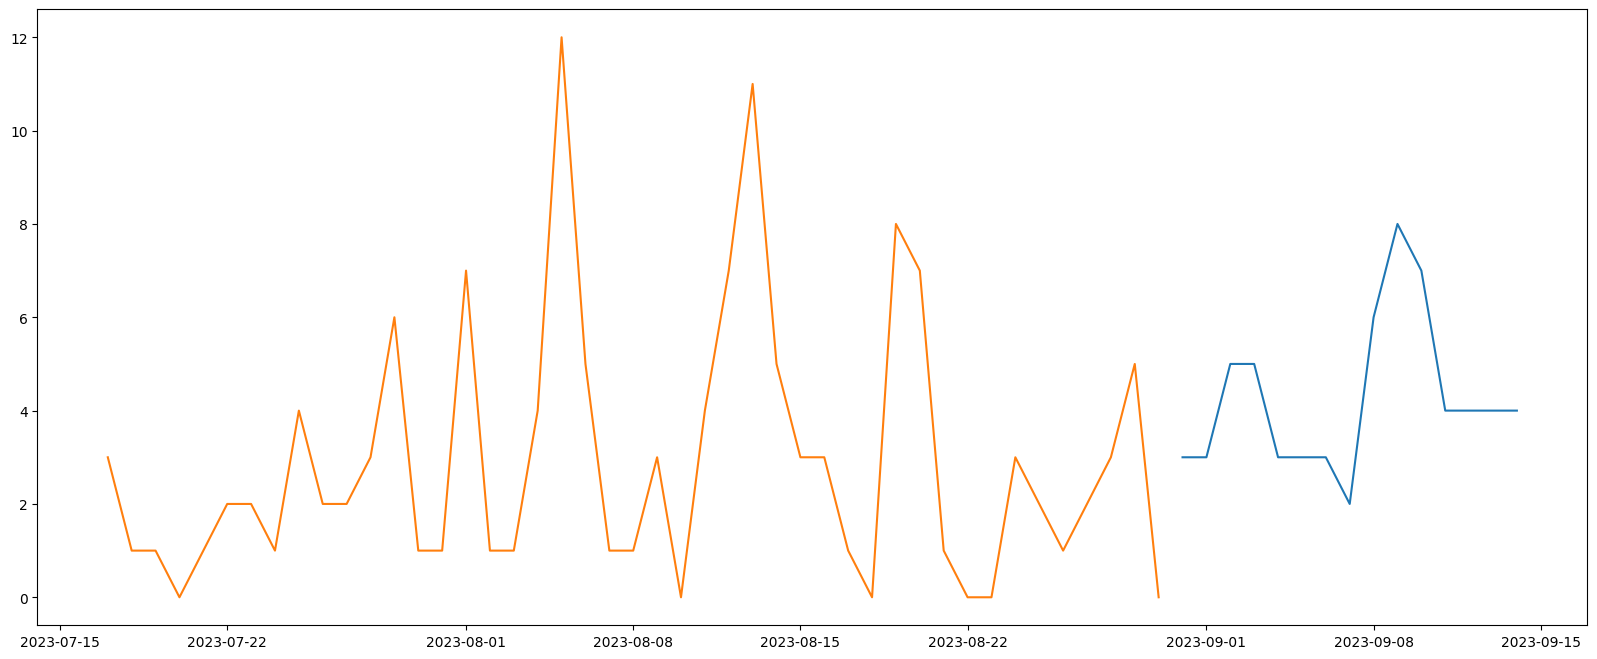

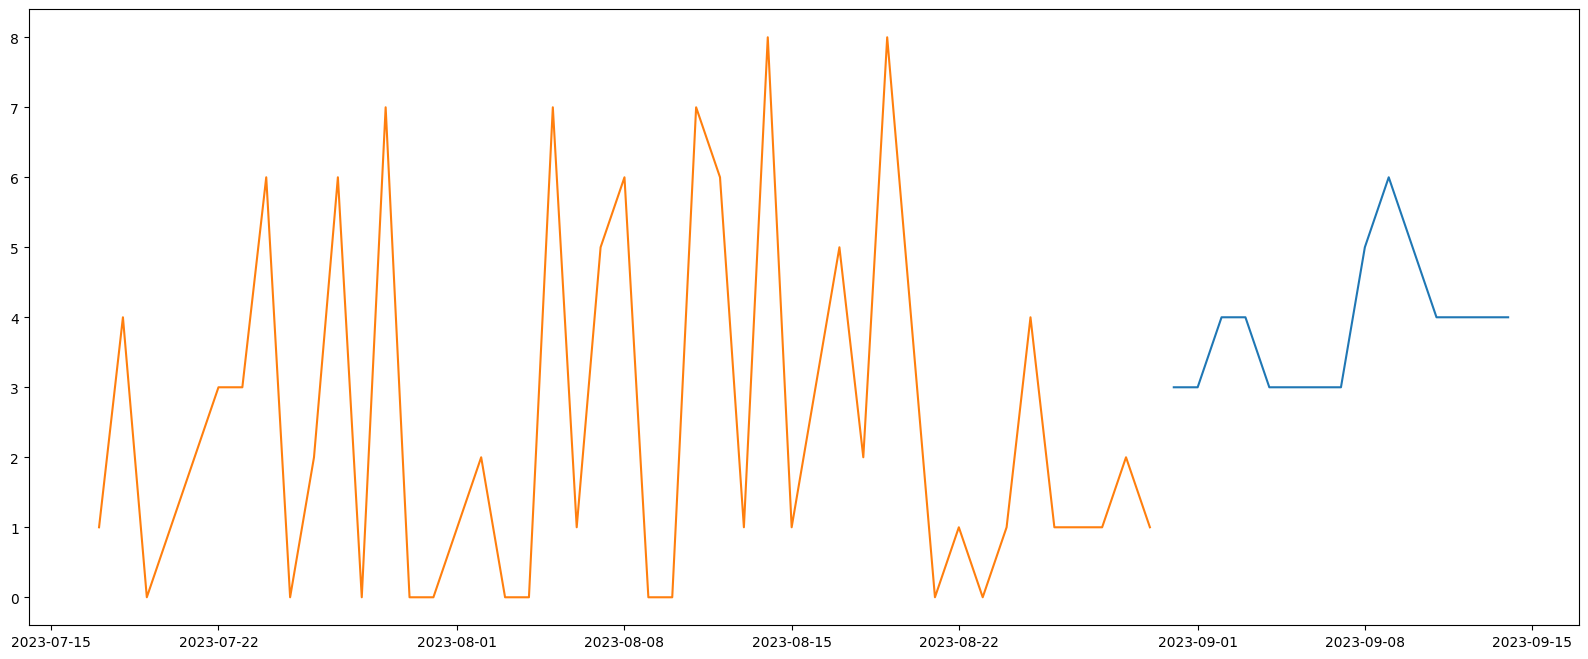

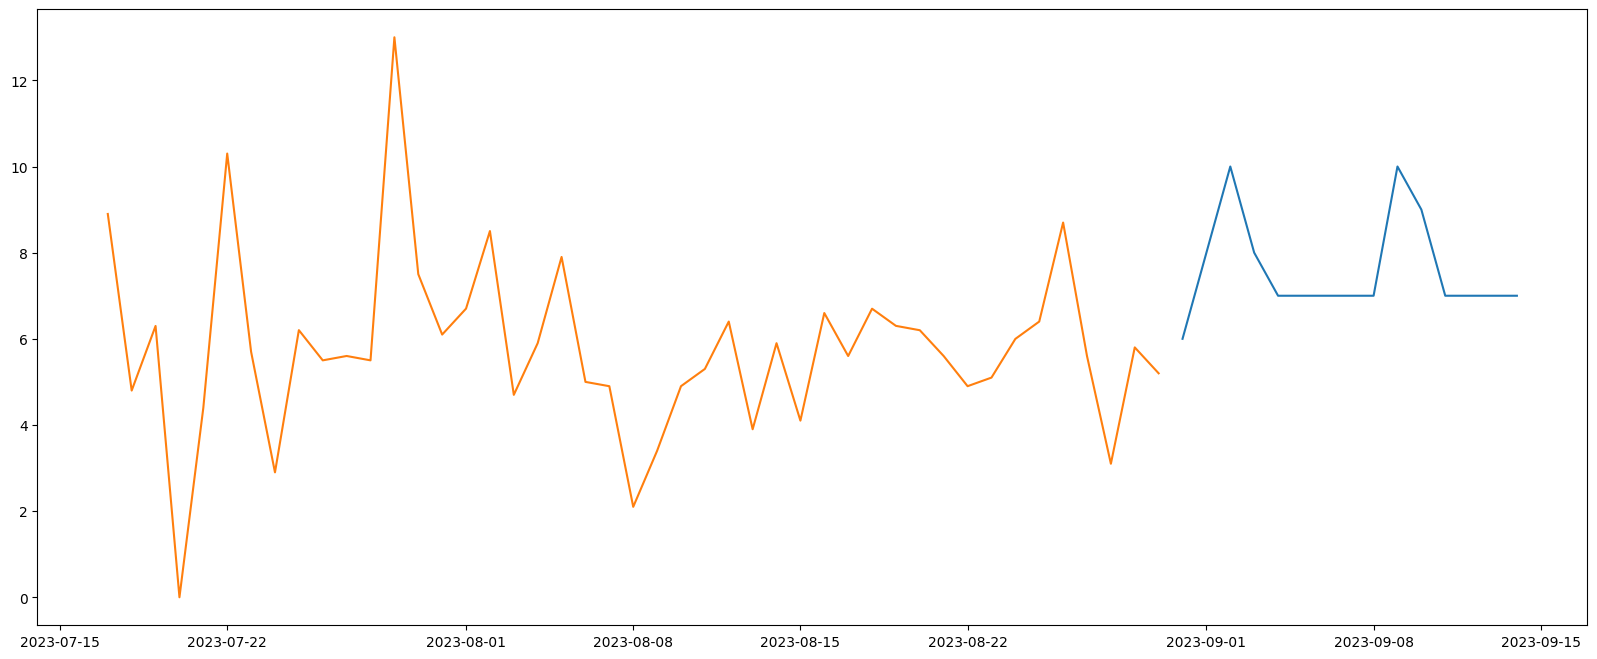

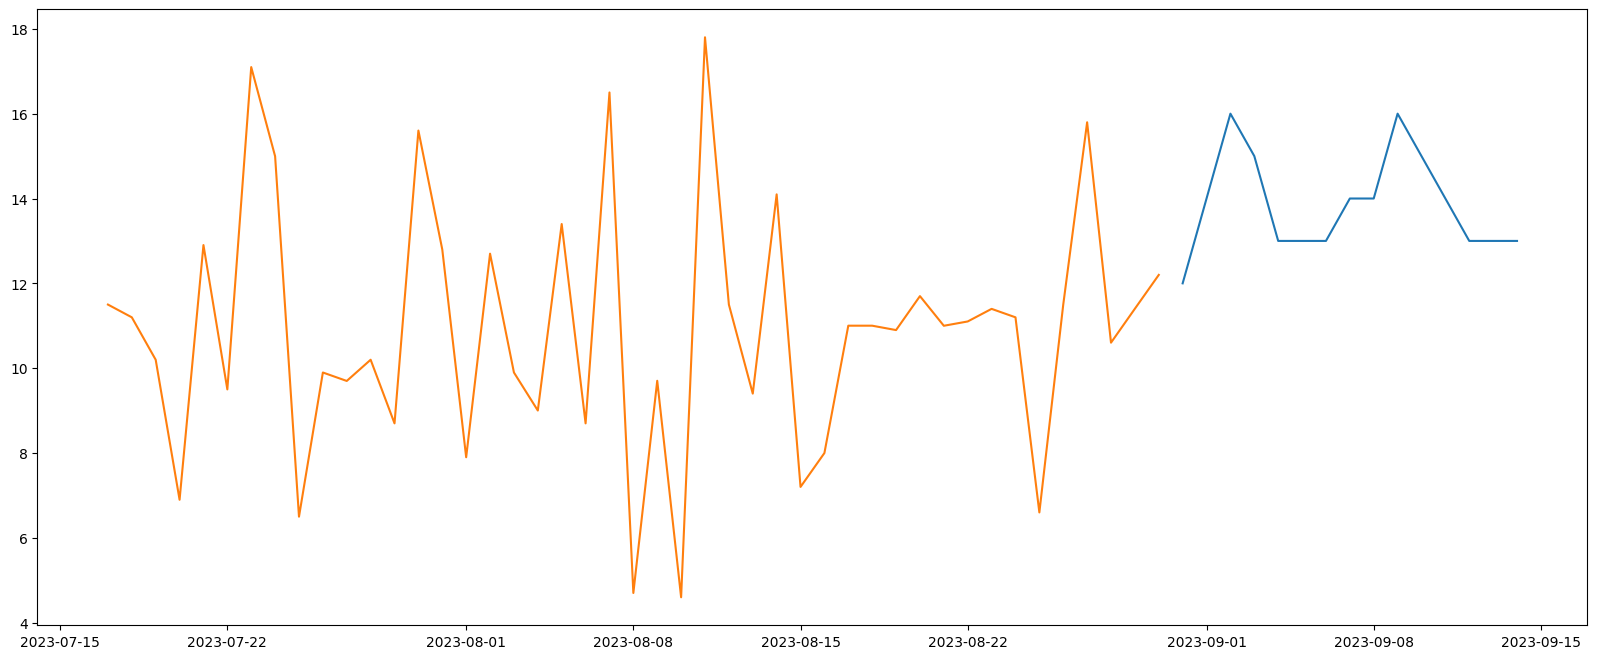

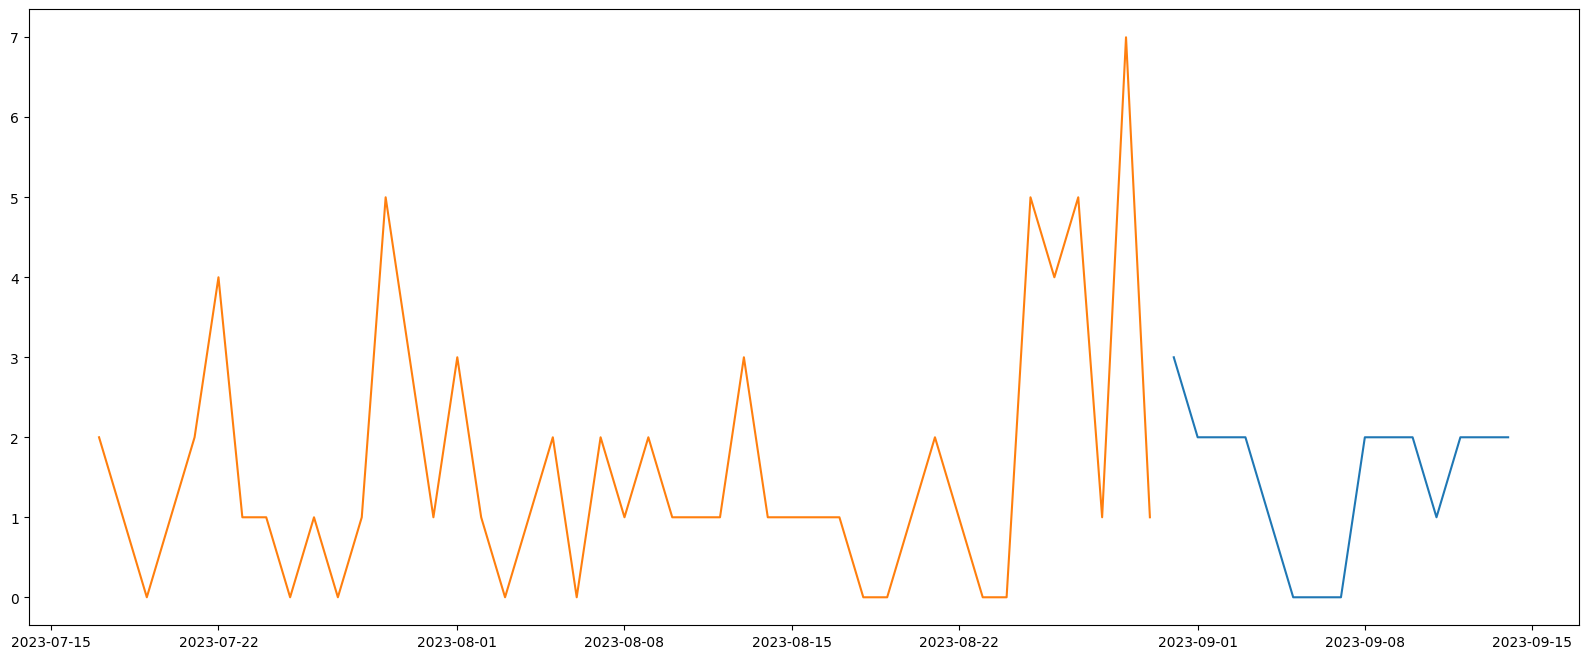

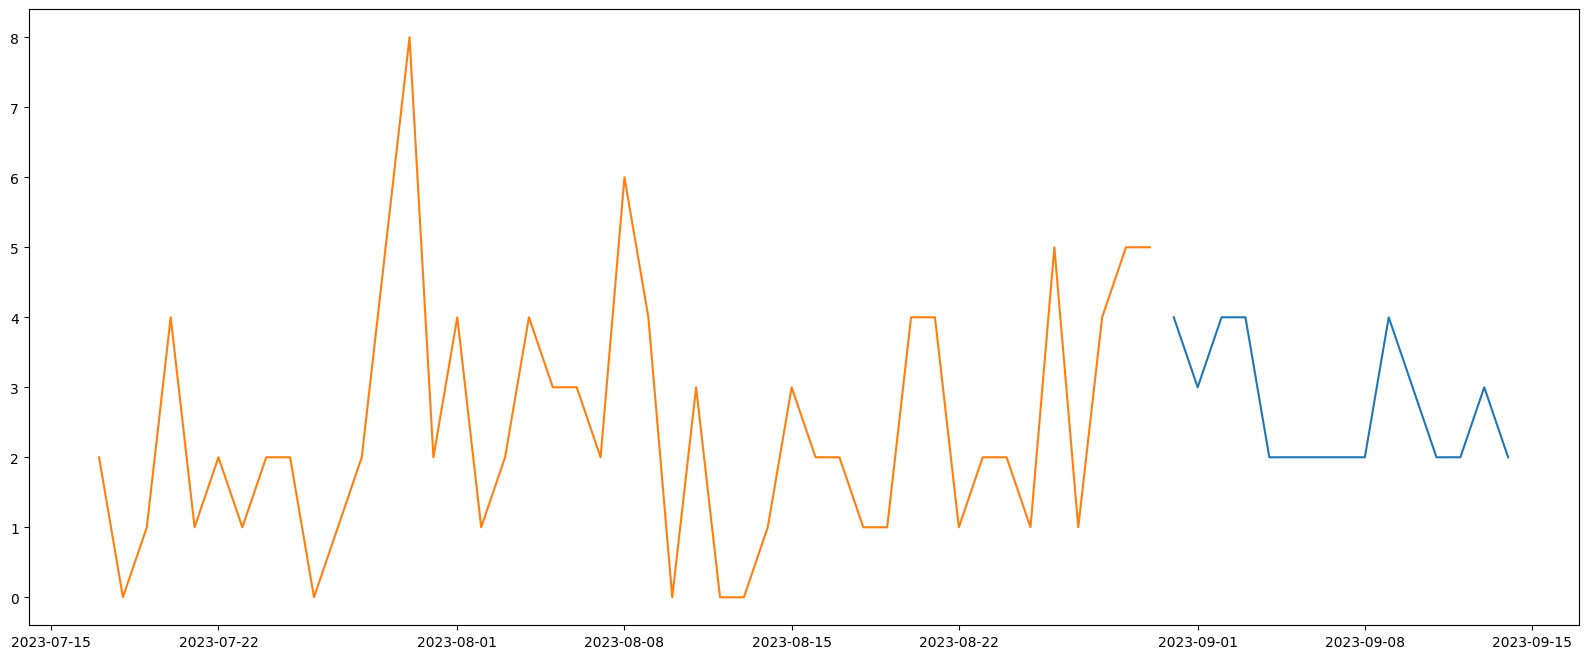

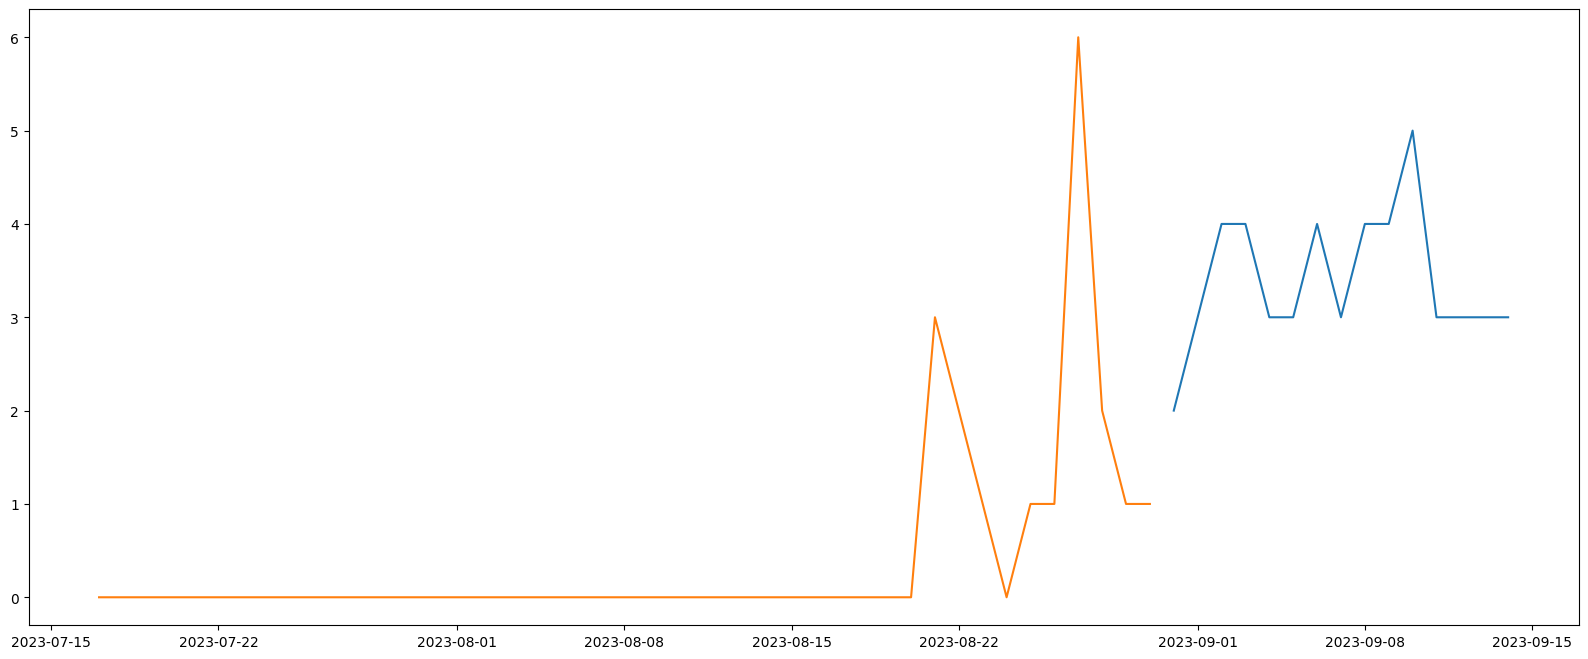

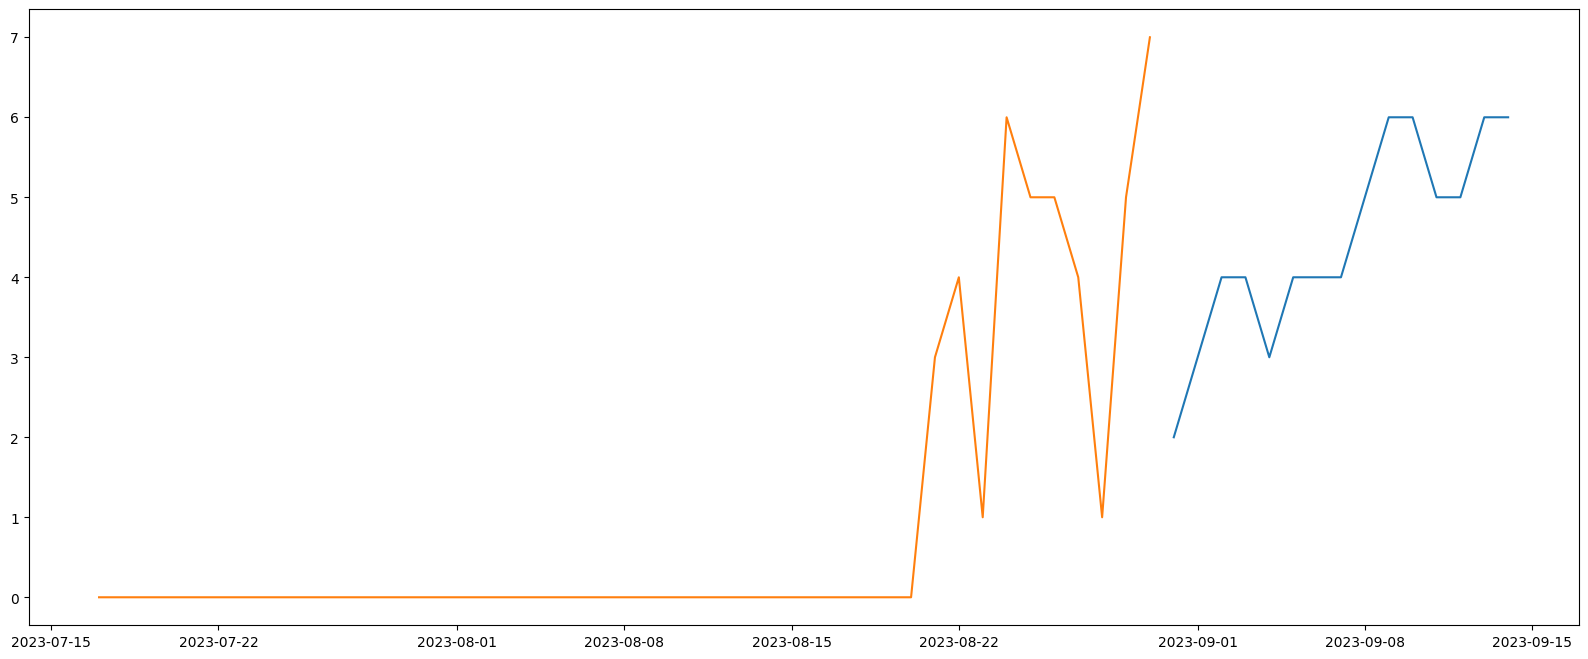

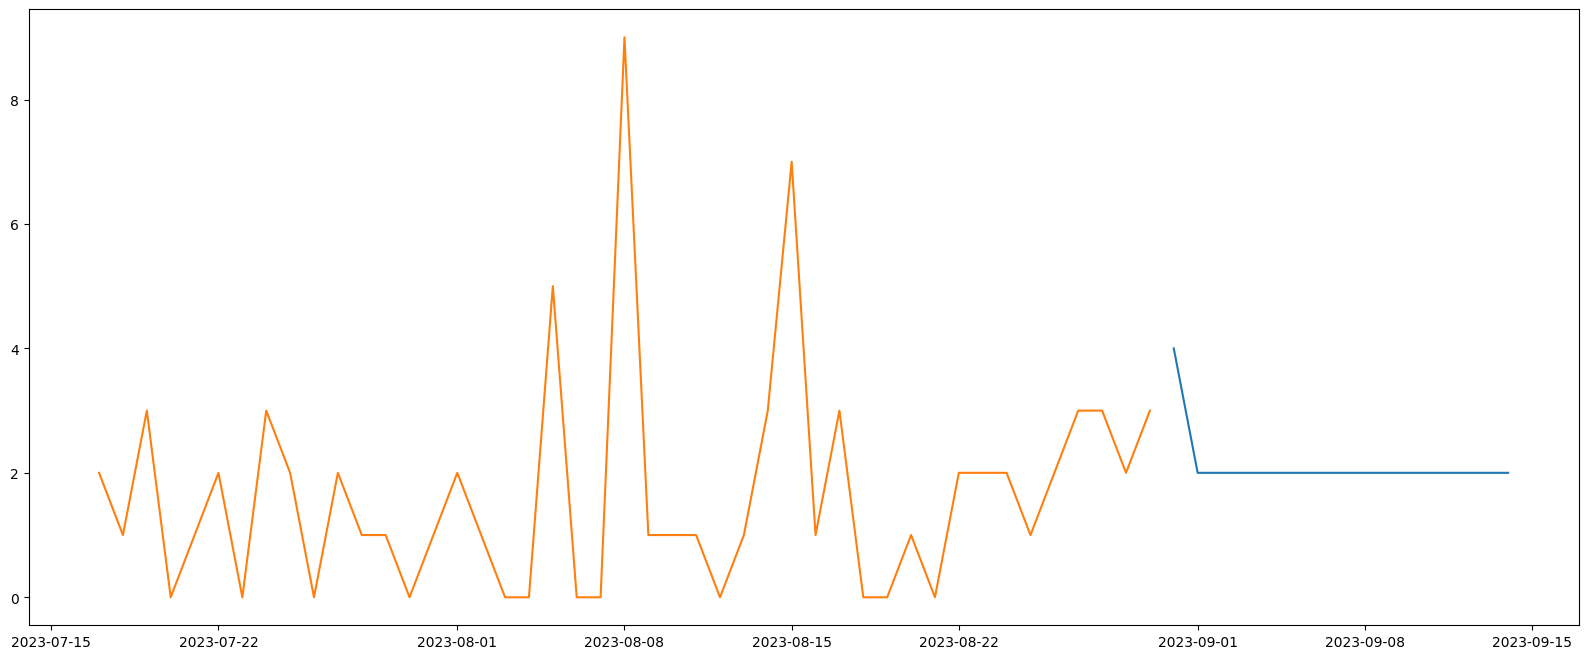

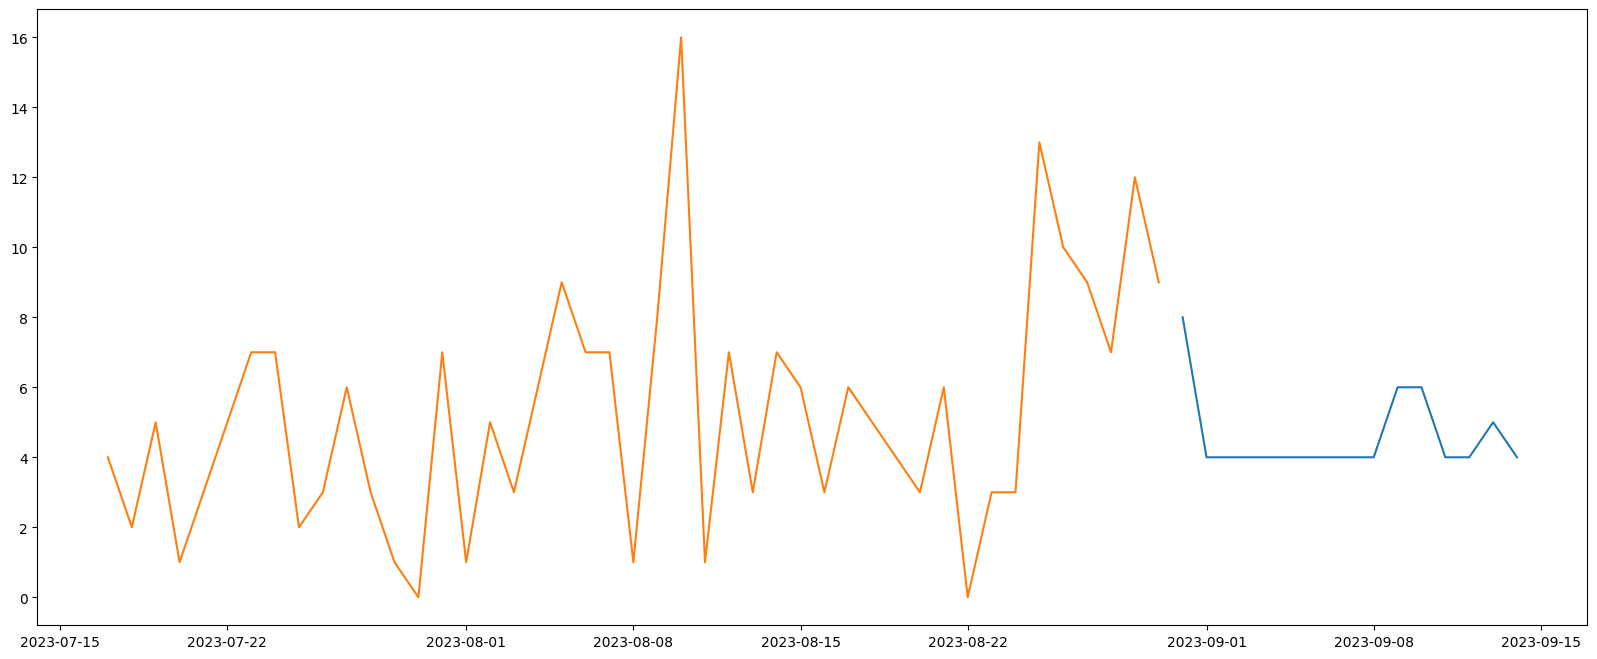

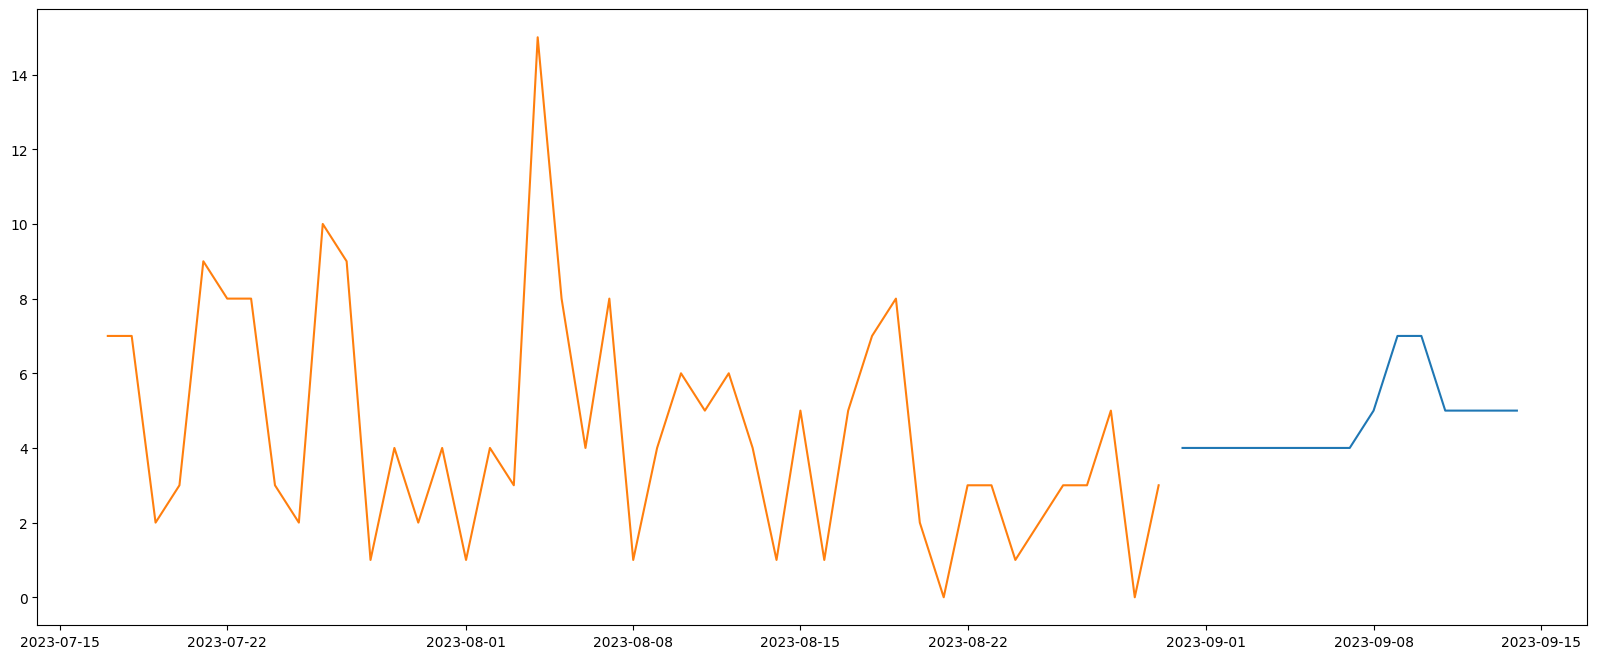

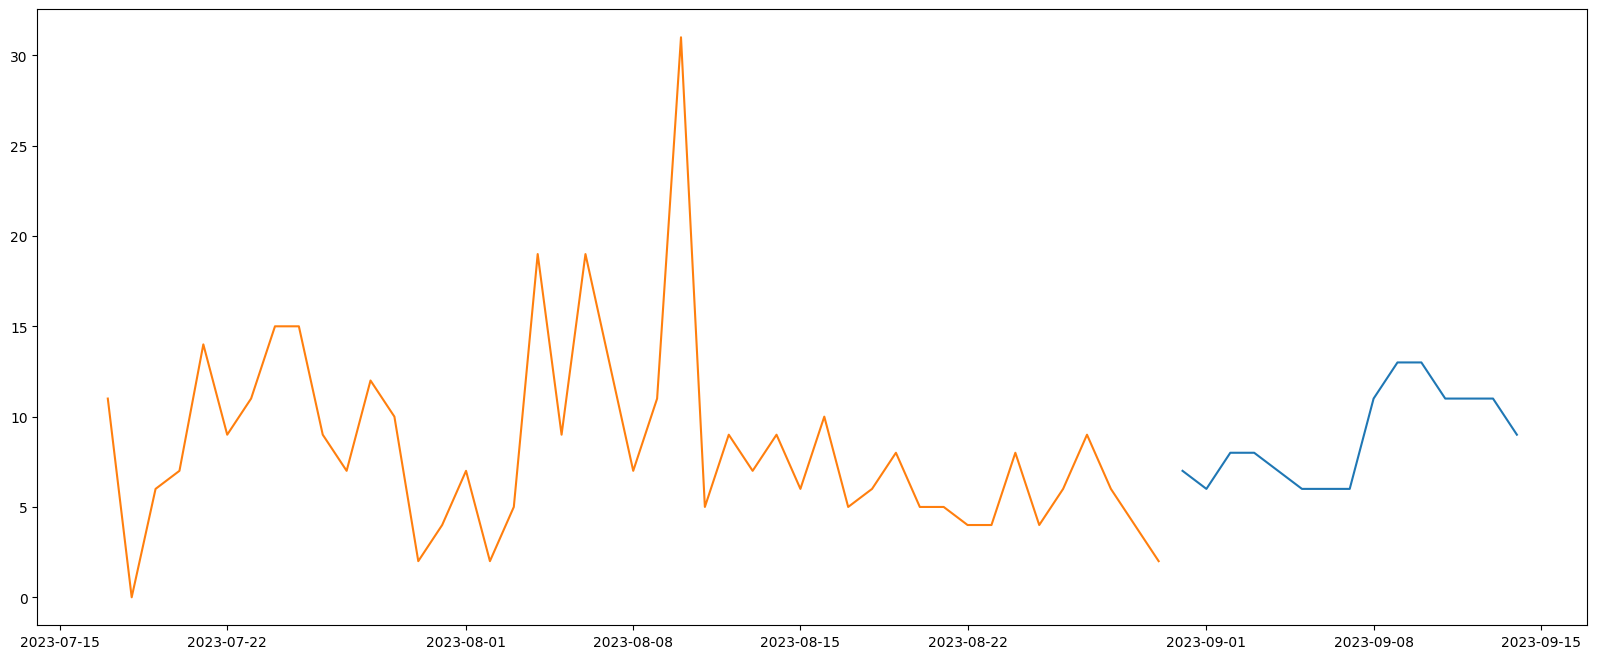

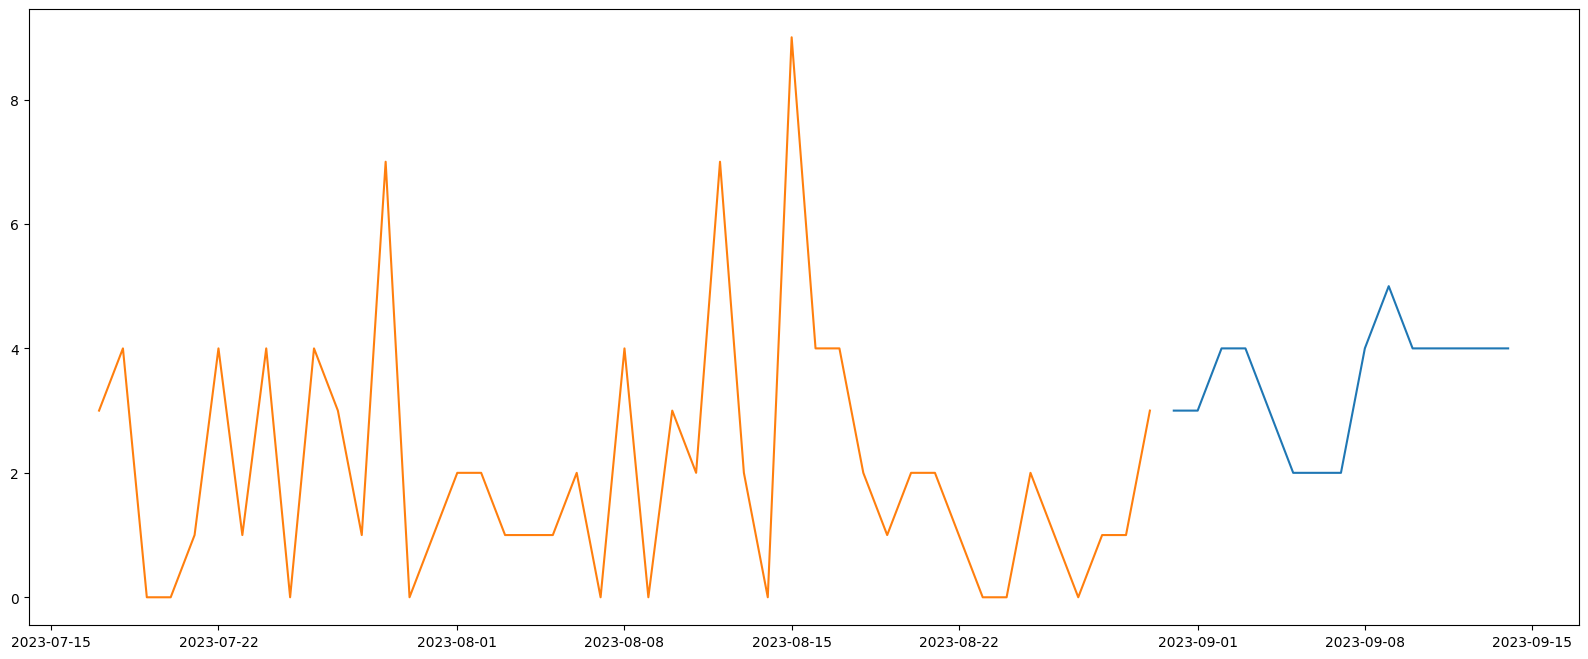

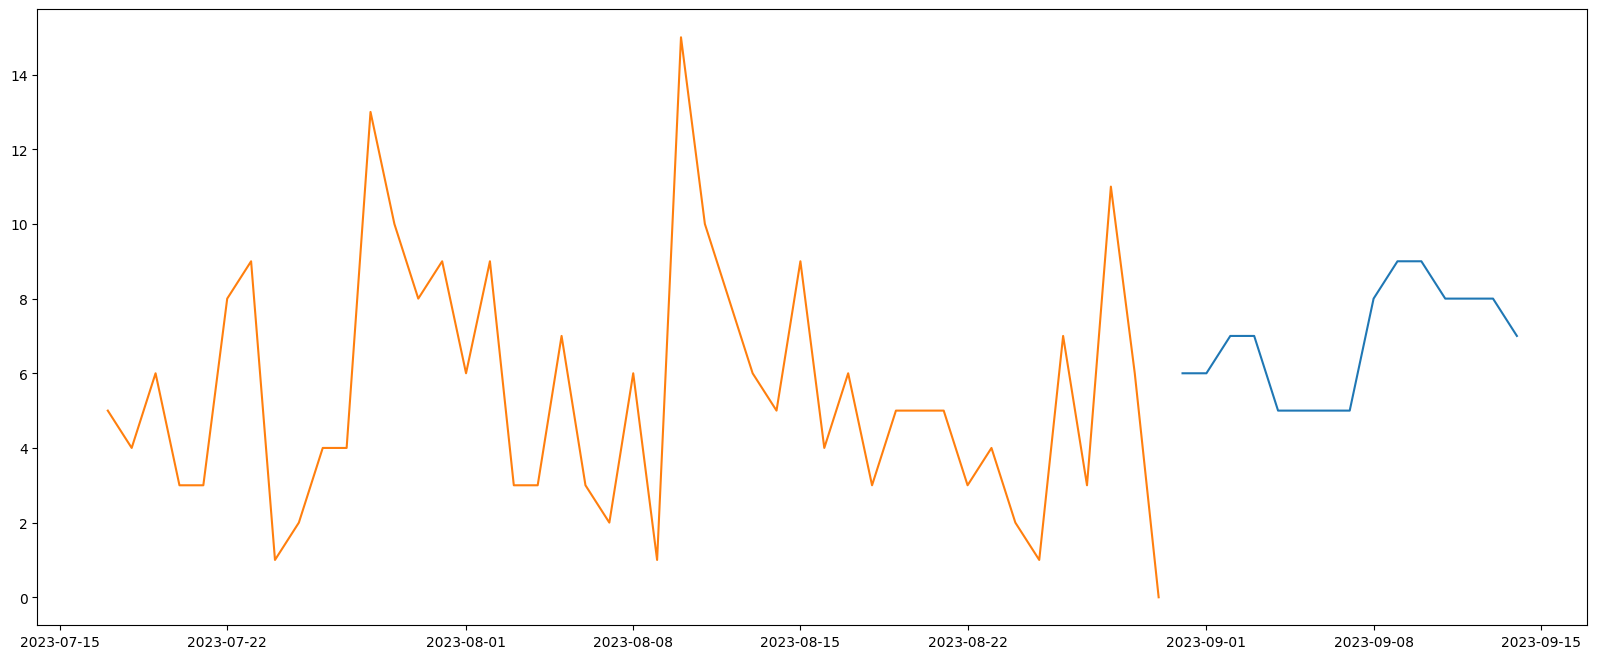

In [25]:
for sku_id in range(40, 50):
    for store_id in [1, 2]:
        temp = ans[(ans['sku_id'] == sku_id) & (ans['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        aaa  = data_merged[(data_merged['sku_id'] == sku_id) & (data_merged['store_id'] == store_id)].groupby(['sku_id', 'store_id', 'date'])['quantity'].sum().reset_index()
        # print(temp)
        plt.figure(figsize=(20, 8))
        plt.plot(temp['date'], temp['quantity'])
        plt.plot(aaa['date'][-60:-15], aaa['quantity'][-60:-15])
        plt.show()

In [26]:
# store_id从1-12，sku_id从1-1000，order_time从2023-08-18到2023-08-31
store_ids = list(range(1, 13))
sku_ids = list(range(1, 1001))
dates = pd.date_range('2023-09-01', '2023-09-14').date

# 生成store_id, sku_id, order_time的笛卡尔积
cartesian = pd.MultiIndex.from_product([store_ids, sku_ids, dates], names=['store_id', 'sku_id', 'date'])
data_now_stocks = pd.DataFrame(cartesian.to_frame(), columns=['store_id', 'sku_id', 'date']).reset_index(drop=True)
data_now_stocks["date"] = pd.to_datetime(data_now_stocks["date"]).dt.date
data_now_stocks

,store_id,sku_id,date
0,1,1,2023-09-01
1,1,1,2023-09-02
2,1,1,2023-09-03
3,1,1,2023-09-04
4,1,1,2023-09-05
...,...,...,...
167995,12,1000,2023-09-10
167996,12,1000,2023-09-11
167997,12,1000,2023-09-12
167998,12,1000,2023-09-13


In [27]:
ans['date'] = pd.to_datetime(ans['date']).dt.date
ans = ans.groupby(['store_id', 'sku_id', 'date'])['quantity'].sum().reset_index()
data_now_stocks = pd.merge(data_now_stocks, ans, how='left')
data_now_stocks.fillna(0, inplace=True)
data_now_stocks

,store_id,sku_id,date,quantity
0,1,1,2023-09-01,2.0
1,1,1,2023-09-02,4.0
2,1,1,2023-09-03,3.0
3,1,1,2023-09-04,2.0
4,1,1,2023-09-05,1.0
...,...,...,...,...
167995,12,1000,2023-09-10,1.0
167996,12,1000,2023-09-11,1.0
167997,12,1000,2023-09-12,1.0
167998,12,1000,2023-09-13,1.0


In [11]:
ans

,store_id,sku_id,date,quantity
0,1,1,2023-08-31,1.446013
1,1,1,2023-09-01,1.744167
2,1,1,2023-09-02,2.586596
3,1,1,2023-09-03,2.357347
4,1,1,2023-09-04,1.459710
...,...,...,...,...
179903,12,1000,2023-09-10,1.271162
179904,12,1000,2023-09-11,0.785540
179905,12,1000,2023-09-12,0.904155
179906,12,1000,2023-09-13,0.897213


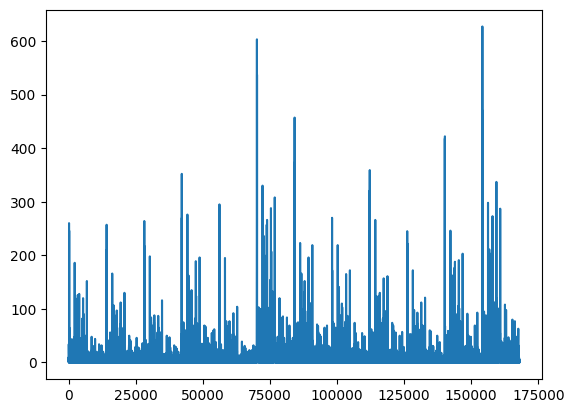

In [28]:
plt.plot(data_now_stocks['quantity'])
plt.show()

In [13]:
temp = pd.read_csv("./data/test/test_results.csv")

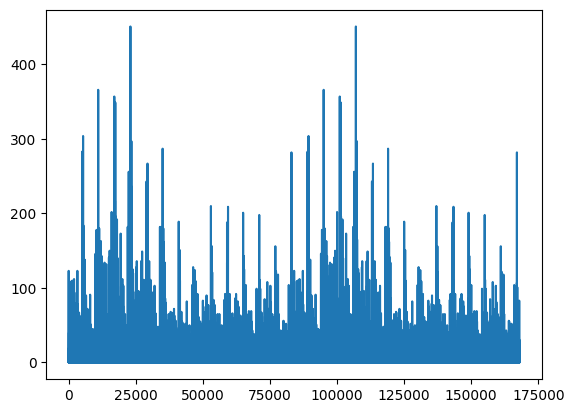

In [14]:
plt.plot(temp['x_k'])
plt.show()

In [15]:
asd &

SyntaxError: invalid syntax (1073862332.py, line 1)

In [16]:
data_now_stocks['quantity'] = np.round(data_now_stocks['quantity'])

In [29]:
data_now_stocks.rename(columns={'quantity': 'x_k'}, inplace=True)
data_now_stocks['x_m'] = 0
data_now_stocks

,store_id,sku_id,date,x_k,x_m
0,1,1,2023-09-01,2.0,0
1,1,1,2023-09-02,4.0,0
2,1,1,2023-09-03,3.0,0
3,1,1,2023-09-04,2.0,0
4,1,1,2023-09-05,1.0,0
...,...,...,...,...,...
167995,12,1000,2023-09-10,1.0,0
167996,12,1000,2023-09-11,1.0,0
167997,12,1000,2023-09-12,1.0,0
167998,12,1000,2023-09-13,1.0,0


In [30]:
data_now_stocks.to_csv("./test_results_rough_lgb.csv", index=False)